In [31]:
import warnings
# hide powerlaw's 'invalid value encountered in true divide' warnings
warnings.filterwarnings('ignore')

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import powerlaw
import pylandstats as pls
import seaborn as sns
import swisslandstats as sls
from scipy import ndimage as ndi

from swiss_urbanization.data import settings

In [32]:
# set default seaborn style
sns.set()

# get default plot dimensions to be used below
figwidth, figheight = plt.rcParams['figure.figsize']

# keyword arguments to be passed to `savefig`
savefig_kws = {
    'dpi': 300,
    'bbox_inches': 'tight',
    'pad_inches': 0
}

In [2]:
urban_class = settings.EXTRACTS_URBAN
nonurban_class = settings.EXTRACTS_NONURBAN
nodata = settings.EXTRACTS_NODATA

agglomeration_slugs = ['bern', 'lausanne', 'zurich']

class_metrics = [
    'proportion_of_landscape', 'area_mn', 'largest_patch_index',
    'edge_density', 'fractal_dimension_am',
    'euclidean_nearest_neighbor_mn', 'landscape_shape_index',
    'patch_density'
]
landscape_metrics = ['contagion', 'shannon_diversity_index']

In [3]:
agglomeration_dict = {}
for agglomeration_slug in agglomeration_slugs:
    ldf = sls.read_csv(
        f'../data/processed/agglomeration_extracts/{agglomeration_slug}.csv')
    landscapes = []
    dates = []
    for urban_nonurban_column in ldf.columns[ldf.columns.str.startswith('AS')]:
        landscapes.append(
            pls.Landscape(
                ldf.to_ndarray(urban_nonurban_column, nodata=nodata),
                res=ldf.res, nodata=nodata))
        # get the year of the snapshot by taking the most recurrent timestamp
        # (year) among the pixels
        dates.append(
            ldf['FJ' + urban_nonurban_column[2:4]].value_counts().index[0])
    agglomeration_dict[agglomeration_slug] = pls.SpatioTemporalAnalysis(
        landscapes, dates=dates)

## Spatiotemporal analysis of the landscape metrics

### Class-level metrics (urban)

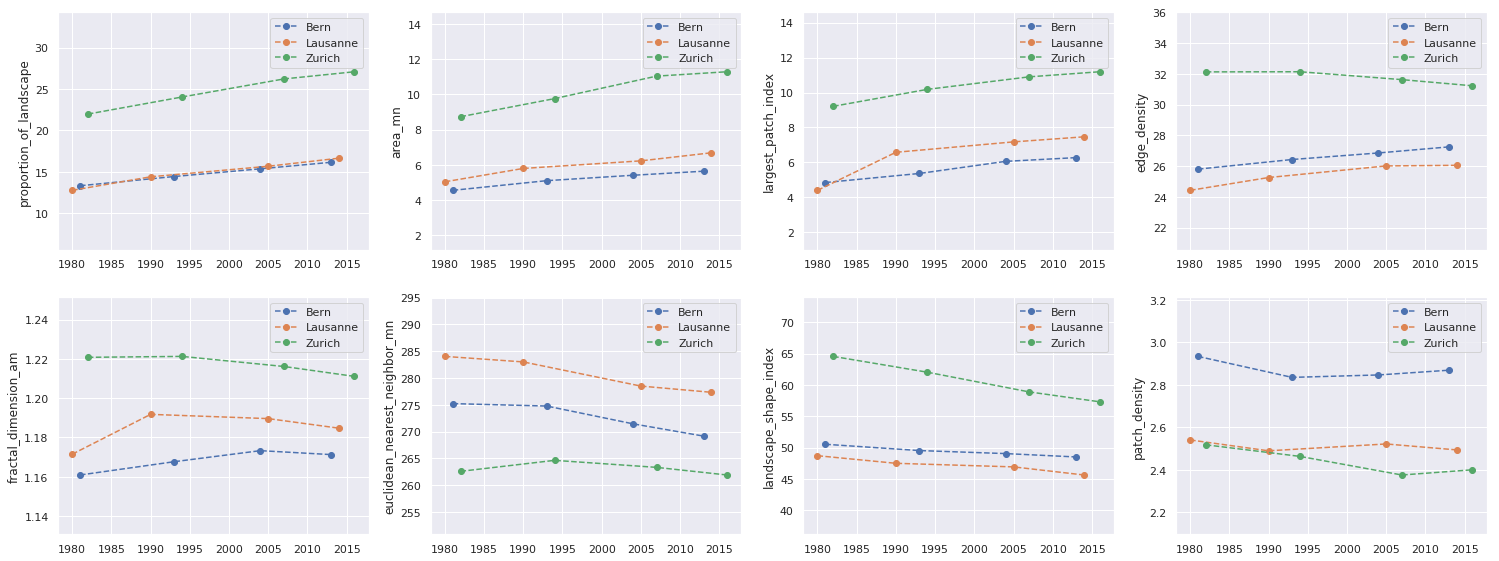

In [18]:
num_cols = 4
num_metrics = len(class_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(class_metrics, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    for agglomeration_slug in agglomeration_slugs:
        agglomeration_dict[agglomeration_slug].plot_metric(
            metric, class_val=1, ax=ax, plot_kws={
                'label': agglomeration_slug.capitalize()})
    ax.margins(y=.5)
    ax.legend()

# fig.suptitle('Metrics for patches of urban classes', fontsize=20, y=.92)
fig.savefig('../reports/figures/class_metrics.pdf', **savefig_kws)

### Landscape level

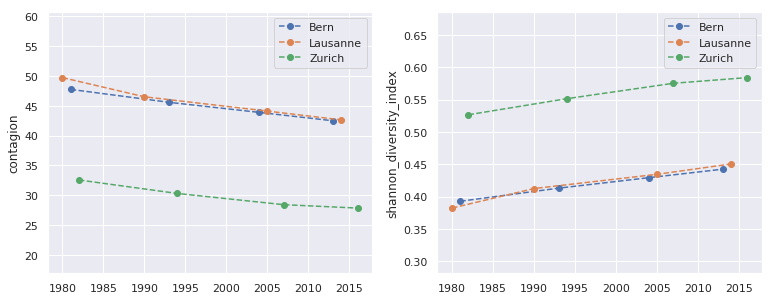

In [17]:
num_cols = 2
num_metrics = len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(landscape_metrics, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    for agglomeration_slug in agglomeration_slugs:
        agglomeration_dict[agglomeration_slug].plot_metric(
            metric, ax=ax, plot_kws={'label': agglomeration_slug.capitalize()})
    ax.margins(y=.5)
    ax.legend()

# fig.suptitle('Landscape-level metrics')
fig.savefig('../reports/figures/landscape_metrics.pdf', **savefig_kws)

## Growth modes

In [21]:
kernel_moore = ndi.generate_binary_structure(2, 2)

def new_patches_label(
        landscape_base_arr, landscape_prime_arr, urban_class_val):
    new_patches_arr = (landscape_prime_arr == urban_class_val) & \
                      (landscape_base_arr != urban_class_val)
    return ndi.label(new_patches_arr, kernel_moore)

def compute_patch_areas(label_arr):        
    return np.bincount(label_arr.ravel())[1:]
    
def compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                       urban_class_val, nonurban_class_val):
    patch_leis = []
    for k in range(1, num_patches + 1):
        patch_arr = label_arr == k
        buffer_zone_arr = ndi.binary_dilation(
            patch_arr, kernel_moore) & ~patch_arr
        buffer_class_values = landscape_prime_arr[buffer_zone_arr]
        area_urban = np.sum(buffer_class_values == urban_class_val)
        area_nonurban = np.sum(buffer_class_values == nonurban_class_val)
        patch_leis.append(area_urban / (area_urban + area_nonurban))

    return patch_leis

In [23]:
def area_weighted_count(patch_areas, cond):
    return np.sum(patch_areas[cond]) / np.sum(patch_areas)

def plot_growth_modes(sta, urban_class_val, nonurban_class_val,
                      weight='number', ax=None, subplots_kws={}):
    if ax is None:
        fig, ax = plt.subplots(**subplots_kws)

    t_range = range(len(sta) - 1)
    # grouped bar plot idea from Chris Albon https://bit.ly/2JrybQ5
    pos = list(t_range)
    width = .25

    leapfrogs = np.zeros(len(t_range))
    edge_expansions = np.zeros(len(t_range))
    infills = np.zeros(len(t_range))
    for t in t_range:
        landscape_base_arr = sta.landscapes[t].landscape_arr
        landscape_prime_arr = sta.landscapes[t + 1].landscape_arr
        label_arr, num_patches = new_patches_label(
            landscape_base_arr, landscape_prime_arr, urban_class_val)
        patch_leis = np.array(
            compute_patch_leis(label_arr, num_patches, landscape_prime_arr,
                               urban_class_val, nonurban_class_val))

        leapfrog_cond = np.isclose(patch_leis, 0)
        edge_expansion_cond = (patch_leis > 0) & (patch_leis <= .5)
        infill_cond = patch_leis > .5
        
        if weight == 'number':
            leapfrog = np.sum(leapfrog_cond) / num_patches
            edge_expansion = np.sum(edge_expansion_cond) / num_patches
            infill = np.sum(infill_cond) / num_patches
        else:  # 'area'
            patch_areas = compute_patch_areas(label_arr)
            leapfrog = area_weighted_count(patch_areas, leapfrog_cond)
            edge_expansion = area_weighted_count(
                patch_areas, edge_expansion_cond)
            infill = area_weighted_count(patch_areas, infill_cond)

        leapfrogs[t] = leapfrog
        edge_expansions[t] = edge_expansion
        infills[t] = infill

    ax.bar(pos, leapfrogs * 100, width, label='leapfrog')
    ax.bar([p + width for p in pos], edge_expansions * 100, width,
           label='edge-expansion')
    ax.bar([p + 2 * width for p in pos], infills * 100, width, label='infill')
    
    # if weight == 'number':
    #     ax.set_ylabel('% patch number')
    # else:  # 'area'
    #     ax.set_ylabel('% area')
    ax.set_xticks([p + width for p in pos])
    ax.set_xticklabels(
        ['{}-{}'.format(sta.dates[t], sta.dates[t+1]) for t in t_range])
    # ax.legend()
    
    return ax

Text(0, 0.5, '% area')

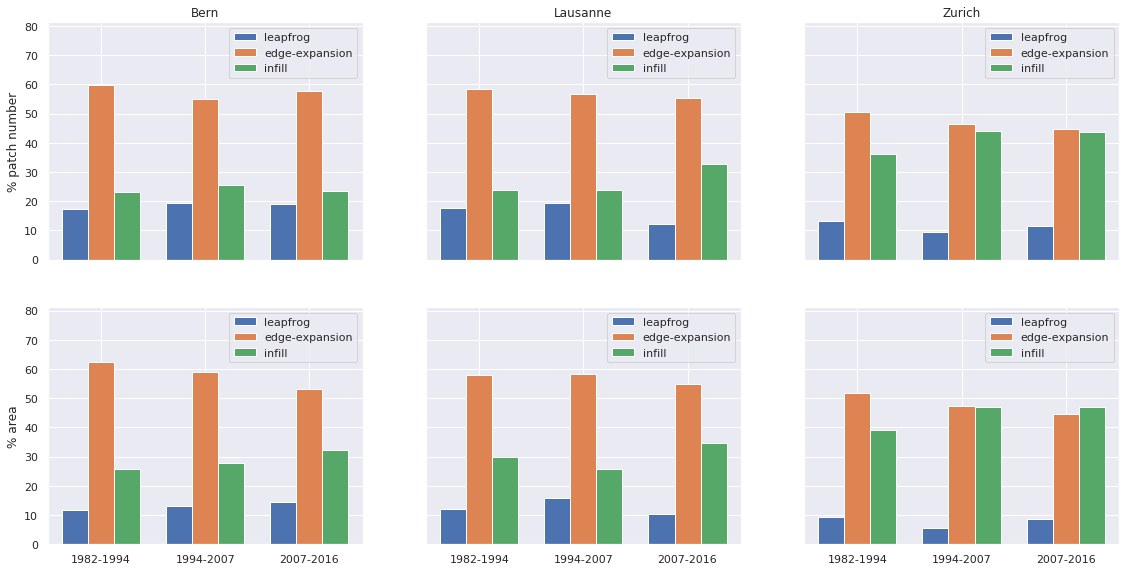

In [29]:
num_agglomerations = len(agglomeration_dict)
num_cols = num_agglomerations
num_rows = 2  # by patch number and by area
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    sharex=True,
    sharey=True,
    figsize=(num_cols * figwidth, num_rows * figheight))

for i, agglomeration_slug in enumerate(agglomeration_slugs):
    agglomeration_sta = agglomeration_dict[agglomeration_slug]
    
    # first plot (above) - by patch number
    ax = axes[0][i]
    ax.set_title(agglomeration_slug.capitalize())
    plot_growth_modes(agglomeration_sta, urban_class, nonurban_class,
                      weight='number', ax=ax)
    ax.margins(y=.3)
    ax.legend()

    # second plot (below) - by area
    ax = axes[1][i]
    plot_growth_modes(agglomeration_sta, urban_class, nonurban_class,
                      weight='area', ax=ax)
    ax.margins(y=.3)
    ax.legend()

fig.axes[0].set_ylabel('% patch number')
fig.axes[num_cols].set_ylabel('% area')
fig.savefig('../reports/figures/growth_modes.pdf', **savefig_kws)

## Self-organized criticality

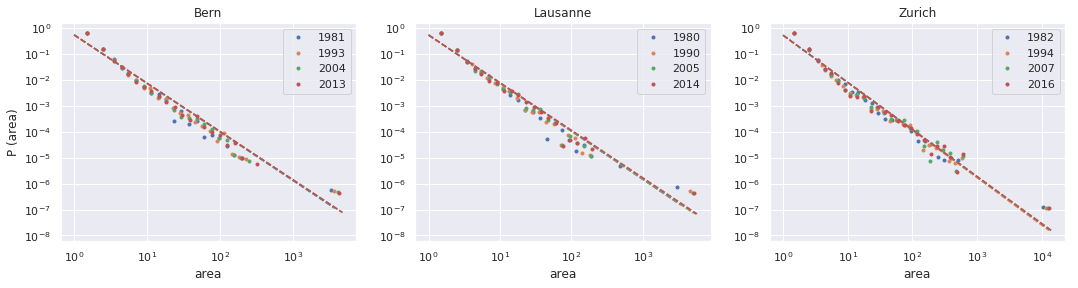

In [36]:
num_cities = len(agglomeration_slugs)
current_palette = sns.color_palette()
fig = plt.figure(figsize=(num_cities * figwidth, figheight))
ax = None  # to pass as `sharey` argument in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    # print(agglomeration_slug.capitalize())
    sta = agglomeration_dict[agglomeration_slug]
    ax = fig.add_subplot(1, num_cities, i, sharey=ax)
    for k, (date, landscape) in enumerate(zip(sta.dates, sta.landscapes)):
        area_ser = landscape.area(urban_class)
       
        ax.set_title(agglomeration_slug.capitalize())
        color = current_palette[k]

        powerlaw.plot_pdf(area_ser, ax=ax, color=color,
                          linestyle='None', marker='.', label=date)
        # `xmin=1` because patches cannot have 0 area
        # `discrete=True` because patches are groups of pixels
        fit = powerlaw.Fit(
            area_ser.values, xmin=1, discrete=True, verbose=False)        
        fit.power_law.plot_pdf(ax=ax, color=color, linestyle='--')

    ax.legend()
    ax.set_xlabel('area')

fig.axes[0].set_ylabel('P (area)')
fig.savefig('../reports/figures/self_organized_criticality.pdf', **savefig_kws)

## Metric correlations

In [23]:
metrics_df = pd.DataFrame(columns=class_metrics + landscape_metrics)
for agglomeration_slug in agglomeration_slugs:
    class_metrics_df = agglomeration_dict[agglomeration_slug].class_metrics_df
    landscape_metrics_df = agglomeration_dict[
        agglomeration_slug].landscape_metrics_df
    agglomeration_metrics_df = pd.concat([
        class_metrics_df.loc[urban_class][class_metrics],
        landscape_metrics_df[landscape_metrics]
    ], axis=1)
    # need minmax scaling for correlations to work
    agglomeration_metrics_df = agglomeration_metrics_df.apply(
        pd.to_numeric).apply(
            lambda x: (x.astype(float) - min(x)) / (max(x) - min(x)), axis=0)
    metrics_df = pd.concat([metrics_df, agglomeration_metrics_df],
                           ignore_index=True)

In [26]:
metrics_df.corr()

metric                         proportion_of_landscape   area_mn  \
metric                                                             
proportion_of_landscape                       1.000000  0.994628   
area_mn                                       0.994628  1.000000   
largest_patch_index                           0.973453  0.967863   
edge_density                                  0.309929  0.289020   
fractal_dimension_am                          0.182301  0.189477   
euclidean_nearest_neighbor_mn                -0.730462 -0.691272   
landscape_shape_index                        -0.987459 -0.991975   
patch_density                                -0.715461 -0.774352   
contagion                                    -0.997935 -0.993336   
shannon_diversity_index                       0.999642  0.995257   

metric                         largest_patch_index  edge_density  \
metric                                                             
proportion_of_landscape                   0.973

In [ ]:
## OLD: Self-organized criticality

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import powerlaw

In [33]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

bern
Scaling range covers a 96.50751547303271% of patches
Scaling range covers a 90.53930530164534% of patches
Scaling range covers a 87.56830601092896% of patches
Scaling range covers a 90.46112115732369% of patches


Calculating best minimal value for power law fit
/home/martibosch/anaconda3/envs/swiss-urbanization/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit



lausanne
Scaling range covers a 89.0992835209826% of patches
Scaling range covers a 92.95039164490862% of patches
Scaling range covers a 95.41237113402062% of patches
Scaling range covers a 95.25547445255475% of patches

zurich
Scaling range covers a 85.69643972517177% of patches
Scaling range covers a 86.93708080485467% of patches


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Scaling range covers a 86.55824759376037% of patches
Scaling range covers a 96.18797239566217% of patches



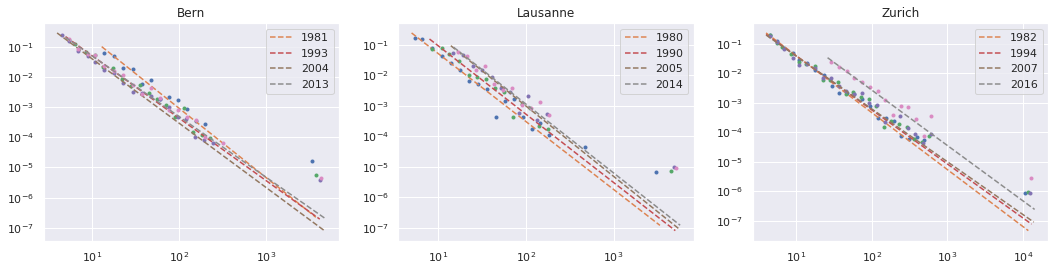

In [41]:
# fig, axes = plt.subplots(1, 3, figsize=(3 * 6, 1 * 6))
num_cities = len(city_slugs)
figwidth, figheight = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=(num_cities*figwidth, figheight))

for i, city_slug in enumerate(city_slugs, start=1):
    print(city_slug)
    sta = city_sta_dict[city_slug]
    # fig, ax = plt.subplots()
    ax = fig.add_subplot(1, num_cities, i)
    for date, landscape in zip(sta.dates, sta.landscapes):
        area_ser = landscape.area(URBAN_CLASS_VAL)

        fit = powerlaw.Fit(area_ser.values)

        print("Scaling range covers a {}% of patches".format(
            np.sum(area_ser < fit.xmin) * 100 / len(area_ser)))

        # fit = powerlaw.Fit(area_ser.values, xmin=1)

        # fig.suptitle(city_slug)
        ax.set_title(city_slug.capitalize())
        fit.plot_pdf(ax=ax, linear_bins=False, linestyle='None', marker='.')
        fit.power_law.plot_pdf(ax=ax, linestyle='--', label=date)

    ax.legend()
    print()

In [15]:
URBAN_CLASS_VAL = 1
NONURBAN_CLASS_VAL = 2

buffer_dists = [5000, 10000, 15000, 20000]

In [ ]:
city_ba_dict = {}

for city_slug in city_slugs:
    agglomeration_geom = gdf[gdf['ANAME'].apply(slugify).str.contains(
        city_slug)]['geometry'].unary_union
    city_ldf = ldf.clip_by_geometry(agglomeration_geom, geometry_crs=gdf.crs)

In [11]:
city_ba_dict = {
    city_slug : pls.BufferAnalysis(
        city_sta_dict[city_slug].landscapes[-1],
        base_mask=gdf[gdf['GMDNAME'].apply(slugify) == city_slug]['geometry'],
        buffer_dists=buffer_dists, landscape_crs=ldf.crs,
        landscape_transform=ldf.affine_transform
    )
    for city_slug in city_slugs
}

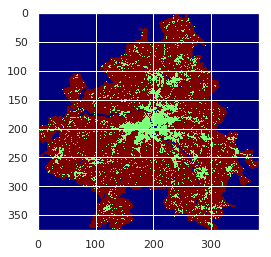

In [22]:
city_sta_dict[city_slug].landscapes[-1].plot_landscape()

In [ ]:
num_cols = 3
num_metrics = len(class_metrics) + len(landscape_metrics)
num_rows = num_metrics // num_cols
if num_metrics % num_cols > 0:
    num_rows += 1

fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))

for i, metric in enumerate(class_metrics, start=1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    for agglomeration_slug in agglomeration_slugs:
        agglomeration_dict[agglomeration_slug].plot_metric(
            metric, class_val=1, ax=ax, plot_kws={'label': agglomeration_slug})
    ax.legend()

for i, metric in enumerate(landscape_metrics, start=len(class_metrics)+1):
    ax = fig.add_subplot(num_rows, num_cols, i)
    for agglomeration_slug in agglomeration_slugs:
        agglomeration_dict[agglomeration_slug].plot_metric(
            metric, ax=ax, plot_kws={'label': agglomeration_slug}) 
    ax.legend()

In [ ]:
num_agglomerations = len(agglomeration_dict)
num_cols = num_agglomerations
num_rows = 2  # by patch number and by area
fig = plt.figure(figsize=(num_cols * figwidth, num_rows * figheight))
ax1 = None  # to pass as `sharey` argument in the first iteration
ax2 = None  # to pass as `sharey` argument in the first iteration

for i, agglomeration_slug in enumerate(agglomeration_slugs, start=1):
    agglomeration_sta = agglomeration_dict[agglomeration_slug]
    
    # first plot (by patch number)
    ax1 = fig.add_subplot(num_rows, num_cols, i, sharex=, sharey=ax1)
    ax1.set_title(agglomeration_slug.capitalize())
    plot_growth_modes(agglomeration_sta, urban_class, nonurban_class,
                      weight='number', ax=ax1)
    ax1.margins(y=.3)
    ax1.legend()

    # scond plot (by area)
    ax2 = fig.add_subplot(num_rows, num_cols, i + num_cols, sharey=ax2)
    plot_growth_modes(agglomeration_sta, urban_class, nonurban_class,
                      weight='area', ax=ax2)
    ax2.margins(y=.3)
    ax2.legend()

fig.axes[0].set_ylabel('% patch number')
fig.axes[num_rows].set_ylabel('% area')    

(<Figure size 1728x288 with 4 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f40e135bef0>,
       dtype=object))

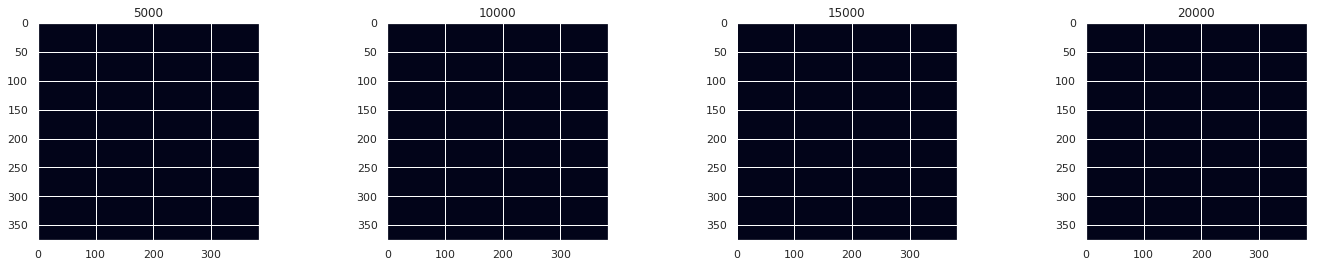

In [20]:
ba.plot_landscapes()